## Introduction

I have just finished my Datacamp's career track on Data Scientist with Python career track.



With this cert, I intend to apply for the AI Apprenticeship Programme found here: https://www.aisingapore.org/industryinnovation/aiap/

While going through the online application, I encountered the following 2 questions: 
    
    AIAP is self-directed, why do you think you would be a good fit for it? *

    Tell us about a technical project you are proud of and elaborate about your role in it. *


I decided to apply what I have recently learned in DataCamp's career track, put them in a Jupyter Notebook and post it to GitHub, a portfolio of sorts. 

I knew of Kaggle and tinkered or rather followed the solutions to competitions. I am aware that the AIAP will have a machine learning component that is part of a 48-hour assessment. So why did I not submit a Kaggle kernel for a machine learning competition? Well, at this late stage, I cannot pretend that I can do up a machine learning kernel all by myself. I can only fork other people's kernel and try to improve on the score with the limited time that I have before the deadline. But doing that would hardly be impressive _(unless I miraculously got into the top 10 postions)_ so I reckon that I should instead attempt to gauge my chances of getting into the AIAP.



## Data, data where art thou?

That's the starting point isn't it? 

Let's assume there are __800__ applications and __30__ admission slots. 
Let's further assume all applicants are homogeneous and possess the same capabilities and criteria for admission.


In [1]:
#number of applications
num_apps = 800

#number admiited
num_admitted =30

print ('Probability that any applicant will be admitted : ' + str( num_admitted/num_apps*100 ) + '%' )

Probability that any applicant will be admitted : 3.75%


### _The end_ ☮

Thanks for reading! Just kidding, please read on.

## Neural Networks
From my limited experience, this seems like a task for neural networks! 

With reference to this helpful article: https://enlight.nyc/projects/neural-network/, let us begin.

Assume there are 3 primary inputs to our neural network, each with a value from 1 to 10: 
    1. Self-directedness 
    2. Technical proficiency
    3. Communication skills
    
The output of the neural network will be a score of 1 or 0. 1 representing admission into the programme.


Since we do not have ready data, we shall create sample data.

## Data Preparation

In [2]:
import numpy as np

np.random.seed(54)

#Randomising our inputs
a=np.random.randint(1,10,num_apps)
b=np.random.randint(1,10,num_apps)
c=np.random.randint(1,10,num_apps)

# X1 = (self-directedness, technical proficiency, communication skills), y1 = 1 or 0 
X1=list(zip(a,b,c))


Now for the 'y', that will be a little bit tricky, as we do want a realistic target variable set, even for make-believe data.

We will have thirty '1's for our target variable set and the rest will be '0'. Now we will want to select a certain top percentile, then randomly allocate our '1's to this top percentile. First, let's explore X.

## Here's looking at you, X

Mean = 5.11125
Standard Deviation = 2.5425290568656718
Mean = 5.0025
Standard Deviation = 2.59921885829987
Mean = 4.8925
Standard Deviation = 2.5820103062394835


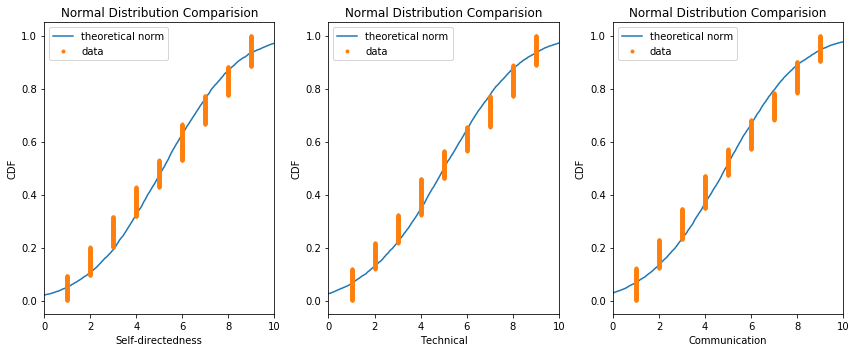

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
%matplotlib inline 
rcParams['figure.figsize'] = (12,5)

#data prep
df = pd.DataFrame(X1)
df.columns = ['Self-directedness' , 'Technical', 'Communication']

#add total column to sum up the attributes for analysis
df['Total'] = df.sum(axis=1)

#ECDF function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

def normal_dist_cmp(var):
    arr= df[var]
    # Compute mean and standard deviation: mu, sigma
    mu = np.mean(arr)
    sigma = arr.std()

    # Sample out of a normal distribution with this mu and sigma: samples
    samples = np.random.normal(mu, sigma, 10000)

    # Get the CDF of the samples and of the data
    x_theor,y_theor=ecdf(samples)
    x,y=ecdf(arr)

    # Plot the CDFs and show the plot
    _ = plt.plot(x_theor, y_theor, label='theoretical norm')
    _ = plt.plot(x, y, marker='.', linestyle='none', label='data')
    _ = plt.xlabel(var)
    _ = plt.ylabel('CDF')
    _ = plt.title('Normal Distribution Comparision')
    _ = plt.legend(loc='best')

    return mu, sigma

plt.subplot(1,3,1)
plt.xlim(0,10)
mu, sigma = normal_dist_cmp('Self-directedness')
print ("Mean = " + str(mu))
print ("Standard Deviation = " + str(sigma))

plt.subplot(1,3,2)
plt.xlim(0,10)
mu, sigma = normal_dist_cmp('Technical')
print ("Mean = " + str(mu))
print ("Standard Deviation = " + str(sigma))

plt.subplot(1,3,3)
plt.xlim(0,10)
mu, sigma = normal_dist_cmp('Communication')
print ("Mean = " + str(mu))
print ("Standard Deviation = " + str(sigma))

plt.tight_layout()
plt.show()


Basically, they looked the same. The attributes pretty much conform to a normal distribution just as would be expected, since they are generated from the same random function.

Similarly, if we were to plot the Total of the attributes. We see a normal distribution as well.

### Getting to y

Next we plot for the Total score.

We will make use of the mean and standard deviation of the Total score. We should allocate the '1's to a subset that is beyond the standard deviation. Let's make it 1.5 times standard deviation.

Mean = 15.00625
Standard Deviation = 4.608172631993921


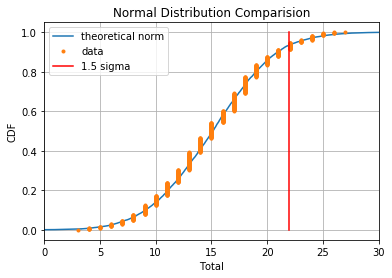

In [4]:
mu, sigma = normal_dist_cmp('Total')
print ("Mean = " + str(mu))
print ("Standard Deviation = " + str(sigma))
plt.xlim(0,30)
plt.grid(True)

#plotting the desired score that is at least 1.5 times sigma
desiredscore = mu + 1.5*sigma
plt.plot([desiredscore,desiredscore], [0,1], '-r', label='1.5 sigma')
plt.legend(loc='best')

plt.show()

Looking at the above chart, it is about the 92nd percentile, which should allow for some variance in data. Given that the admission rate is 3.75%  Some top-percentiled applicants may change their minds for varying reasons and not accept the offer when offered admission. Hence it should be reasonable to randomly allocate the '1's to this subset scoring 22 and above.

Let me lay down the plan of attack at this point:

    1. create a target variable in our dataset called 'Target' and initialise all to 0.

    2. extract the subset of the top percentile that scored 22 and above.
    
    3. randomly assign the value 1 to the 'Target' variable of 30 applicants in this subset.

Here's the code:


In [5]:
#initialise all targets to 0
df['Target'] = 0

print('Number of applicants who scored 22 and above : ' + str( len(df[df['Total']>=22]) ) )

#retrieve array of indices of applicants who scored 22 and above
top_idx = df[df['Total']>=22].index
top_idx = list(top_idx)

#random selection of admitted applicants
import random
random.seed(23)
selected_idx = random.sample(top_idx, num_admitted)  #this is a different function from np.random.sample

#assign 1 to Target
for i in selected_idx:
    df.loc[i,'Target']=1

print('Number of applicants who are admitted : ' + str( len(df[df['Target']==1]) ) )    

#test whether our plan worked
assert(len(df[df['Target']==1]) == num_admitted)

Number of applicants who scored 22 and above : 70
Number of applicants who are admitted : 30


Our plan worked! We now have our apprentices for the AIAP!

Let's print out the list:


In [6]:
print(df[df['Target']==1])

     Self-directedness  Technical  Communication  Total  Target
16                   7          9              8     24       1
24                   9          9              9     27       1
26                   8          9              9     26       1
53                   9          9              4     22       1
81                   8          8              8     24       1
100                  9          7              8     24       1
144                  7          9              9     25       1
168                  9          7              8     24       1
182                  9          6              7     22       1
186                  6          9              8     23       1
209                  9          9              8     26       1
230                  6          9              8     23       1
260                  8          6              8     22       1
293                  6          7              9     22       1
305                  6          8       

Now let's get our y! We also add a new feature Total to X.

In [7]:
y = np.array(df['Target'])

#needs to reshape to 2D
y = y.reshape((y.shape[0], 1))

#add new feature Total
total = df['Total'].values
total = total.reshape((total.shape[0], 1))

X1 = np.array(X1)
X2 = np.append(X1, total, axis=1)

print (X2.shape)
print (y.shape)

(800, 4)
(800, 1)


Lastly, we scale the units (also known as normalisation) so that the training is improved, accurate and faster.

In [8]:
# scale units
X = X2/np.amax(X2, axis=0) # maximum of X array


## Creating a neural network class

In [9]:
class Neural_Network(object):
  def __init__(self):
    #parameters
    self.inputSize = 4
    self.outputSize = 1
    self.hiddenSize = 4

    #weights
    self.W1 = np.random.randn(self.inputSize, self.hiddenSize) # (4x4) weight matrix from input to hidden layer
    self.W2 = np.random.randn(self.hiddenSize, self.outputSize) # (4x1) weight matrix from hidden to output layer

  def forward(self, XX):
    #forward propagation through our network
    self.z = np.dot(XX, self.W1) # dot product of X (input) and first set of 4x4 weights
    self.z2 = self.relu(self.z) # activation function
    self.z3 = np.dot(self.z2, self.W2) # dot product of hidden layer (z2) and second set of 4x1 weights
    o = self.relu(self.z3) # final activation function using relu
    return o

  def sigmoid(self, s):
    # activation function
    return 1/(1+np.exp(-s))
  
  def sigmoidPrime(self, s):
    #derivative of sigmoid
    return s * (1 - s)

  def relu(self, r):
    return np.maximum(0, r)

  def backward(self, XX, yy, oo):
    # backward propagate through the network
    self.o_error = yy - oo # error in output
    self.o_delta = self.o_error*oo # applying derivative of relu (which is actually oo) to error

    self.z2_error = self.o_delta.dot(self.W2.T) # z2 error: how much our hidden layer weights contributed to output error
    self.z2_delta = self.z2_error*self.sigmoidPrime(self.z2) # applying derivative of sigmoid to z2 error

    self.W1 += XX.T.dot(self.z2_delta) # adjusting first set (input --> hidden) weights
    self.W2 += self.z2.T.dot(self.o_delta) # adjusting second set (hidden --> output) weights

  def train(self, XX, yy):
    oo = self.forward(XX)
    self.backward(XX, yy, oo)
  
  def saveWeights(self):
    np.savetxt("w1.txt", self.W1, fmt="%s")
    np.savetxt("w2.txt", self.W2, fmt="%s")  
    
  #for debugging
  def W1(self):
    return self.W1

  def W2(self):
    return self.W2

NN = Neural_Network()

#defining our output
o = NN.forward(X)

#Printing the sample outputs
print ("Predicted Output: \n" + str(o[16:27])) 
print ("Actual Output: \n" + str(y[16:27]))

Predicted Output: 
[[0.79491503]
 [0.54292678]
 [0.51726622]
 [0.34818167]
 [0.40340588]
 [0.41529409]
 [0.35718479]
 [0.55226923]
 [0.90689974]
 [0.3892942 ]
 [0.86101798]]
Actual Output: 
[[1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]]


Now that's an untrained neural network.

We shall now do some training for our neural network.

## Backpropagation 

Or training with weights (_Honey, I am gonna go to the gym for some backpropagation!!_)


In [10]:
for i in range(10): # trains the NN 10 times
  #print samples
  print ("Training #" + str(i+1) + "\n" )    
  print ("Input: \n" + str(X[16:27]) )
  print ("Actual Output: \n" + str(y[16:27]) )
  o = NN.forward(X)
  print ("Predicted Output: \n" + str(o[16:27]) )
  print ("Loss: \n" + str( np.mean( np.square(y - o) ) )  )# mean sum squared loss
  print ("\n" )
  NN.train(X, y)

Training #1

Input: 
[[0.77777778 1.         0.88888889 0.88888889]
 [1.         0.22222222 0.33333333 0.51851852]
 [0.88888889 0.22222222 0.44444444 0.51851852]
 [0.44444444 0.33333333 0.33333333 0.37037037]
 [0.33333333 0.33333333 0.88888889 0.51851852]
 [0.22222222 0.77777778 0.44444444 0.48148148]
 [0.33333333 0.44444444 0.44444444 0.40740741]
 [0.77777778 0.22222222 0.88888889 0.62962963]
 [1.         1.         1.         1.        ]
 [0.22222222 0.88888889 0.11111111 0.40740741]
 [0.88888889 1.         1.         0.96296296]]
Actual Output: 
[[1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]]
Predicted Output: 
[[0.79491503]
 [0.54292678]
 [0.51726622]
 [0.34818167]
 [0.40340588]
 [0.41529409]
 [0.35718479]
 [0.55226923]
 [0.90689974]
 [0.3892942 ]
 [0.86101798]]
Loss: 
0.2606619038720009


Training #2

Input: 
[[0.77777778 1.         0.88888889 0.88888889]
 [1.         0.22222222 0.33333333 0.51851852]
 [0.88888889 0.22222222 0.44444444 0.51851852]
 [0.44444444 0.33333333 0

We quickly got to a loss value of 0.0375 which is equal to the probability of admission we calculated earlier. 


## Conclusion

The neural network implemented here did not work well. It will _not_ be capable of predicting the admission of an applicant. At first I tried only the 3 features of 'Self-directness, Technical competency and Communication skills'.
Then I added the 'Total' feature thinking it will help. 

So why did it not work? Maybe a neural network is not suited for this analysis, maybe the data was flawed. Maybe more features are needed.

There is much to learn beyond learning Python for Data Science. The more I learn in Data Science, the more I realised how much I still do not know. It has been exciting embarking on this project and trying out a neural network. I could have used Keras but I wanted to see how the forward feed and backpropagation feels like.  All is not lost, I can probably reuse what I have here on some more suitable data sets. And there so many other methods out there to try out and data science seems to be evolving rapidly in exponential fashion! But first I probably need to finish this in-depth introduction to machine learning: https://www.r-bloggers.com/in-depth-introduction-to-machine-learning-in-15-hours-of-expert-videos/

Thank you for reading! ☮